# Validation of the method for estimating CH4 climate impacts related to NOx emissions

In [1]:
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from utils.functions import emission_profile_function
from metrics.metrics import co2_ipcc_pulse_absolute_metrics, absolute_metrics, relative_metrics
from climate_models.co2_ipcc_climate_model import co2_ipcc_climate_model
from climate_models.gwpstar_climate_model import species_gwpstar_climate_model
from climate_models.lwe_climate_model import species_lwe_climate_model
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model

## Parameters

In [2]:
unit_value_o3 = 1
sensitivity_erf_o3 = 34.4e-12 * (14/46)
ratio_erf_rf_o3 = 1.37
efficacy_rf_o3 = 1
efficacy_erf_o3 = 1

unit_value_ch4 = 1
sensitivity_erf_ch4 = -0.695e-9
ratio_erf_rf_ch4 = 1.18
efficacy_rf_ch4 = 1
efficacy_erf_ch4 = 1

start_year = 1940
end_year = 2018
tcre = 0.00045

In [3]:
klower_data_df = read_csv("climate_data/historical_data_from_klower.csv", delimiter=";")
klower_data = klower_data_df.values
klower_data_years = klower_data[:, 0]
klower_data_co2 = klower_data[:, 1]
klower_data_distance = klower_data[:, 2]
aeromaps_data_co2 = klower_data[:, 3]

emission_index_nox = 0.01514
species_quantities = klower_data_co2 / 3.15 * emission_index_nox * 1e9 # [MtNOx to kgNOx]

# for k in range(1990-1940, 2018-1940+1):
#     species_quantities[k] = 0

## Metrics calculation

In [4]:
species_settings_o3 = {"sensitivity_erf": sensitivity_erf_o3, "ratio_erf_rf": ratio_erf_rf_o3, "efficacy_erf": efficacy_erf_o3}
species_settings_ch4 = {"sensitivity_erf": sensitivity_erf_ch4, "ratio_erf_rf": ratio_erf_rf_ch4, "efficacy_erf": efficacy_erf_ch4}
model_settings = {"tcre": tcre}
radiative_forcing_o3, effective_radiative_forcing_o3, temperature_o3 = species_lwe_climate_model(start_year, end_year, "Aviation NOx - ST O3 increase", species_quantities, species_settings_o3, model_settings)
radiative_forcing_ch4, effective_radiative_forcing_ch4, temperature_ch4 = species_lwe_climate_model(start_year, end_year, "Aviation NOx - CH4 decrease and induced", species_quantities, species_settings_ch4, model_settings)

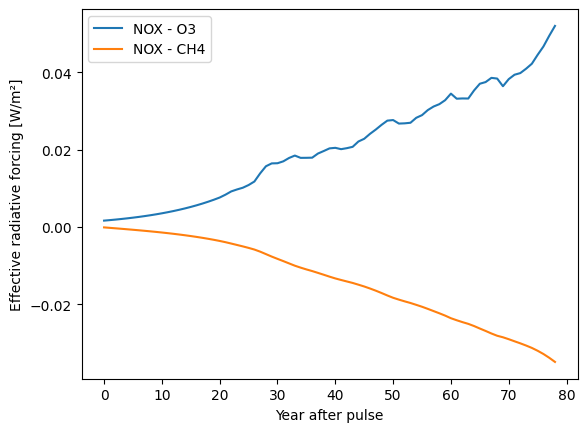

In [5]:
plt.plot(effective_radiative_forcing_o3, label='NOX - O3')
plt.plot(effective_radiative_forcing_ch4, label='NOX - CH4')
plt.xlabel('Year after pulse')
plt.ylabel('Effective radiative forcing [W/m²]')
plt.legend()

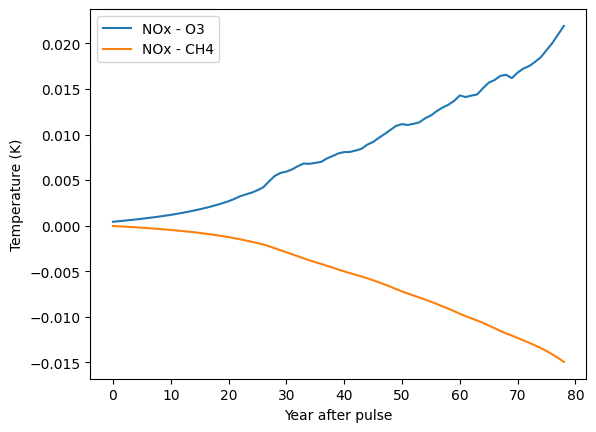

In [6]:
plt.plot(temperature_o3, label='NOx - O3')
plt.plot(temperature_ch4, label='NOx - CH4')
plt.xlabel('Year after pulse')
plt.ylabel('Temperature (K)')
plt.legend()

In [7]:
print(1000*effective_radiative_forcing_o3[65], 1000*effective_radiative_forcing_o3[71], 1000*effective_radiative_forcing_o3[78])
print(1000*effective_radiative_forcing_ch4[65], 1000*effective_radiative_forcing_ch4[71], 1000*effective_radiative_forcing_ch4[78])

37.053869463188406 39.38419649669566 52.01621394141836
-26.293393215678343 -29.594044177999166 -34.93372051903955
